No GPU available, using the CPU instead.


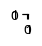

In [1]:
%load_ext autoreload
%autoreload 2
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 180
sns.set_style('darkgrid')

import warnings
warnings.filterwarnings("ignore")

from tqdm.auto import tqdm
from datetime import datetime as dt
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, display_side
from src.data_processing import get_dataset, BL62_VALUES, BL62FREQ_VALUES, HLAS, AA_KEYS
from src.metrics import get_predictions, get_roc, get_metrics, plot_roc_auc_fold, get_mean_roc_curve
from src.metrics import get_nested_feature_importance, plot_feature_importance
from src.partition_tools import pipeline_stratified_kfold
from src.utils import pkl_load, pkl_dump
from src.baselines import plot_baseline_roc, plot_related_baseline_roc
from src.models import FFNetPipeline

PAL = sns.color_palette('hsv', n_colors=13)
HSV = [PAL[-4], PAL[-1], PAL[0], PAL [4]]
mpl.rcParams['figure.dpi'] = 180

import torch
from torch import optim, nn
import torch.functional as F
from torch.utils.data import DataLoader, TensorDataset

if torch.cuda.is_available():
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name())
    device="cuda:0"
else:
    print('No GPU available, using the CPU instead.')
    device='cpu'

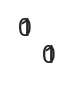

In [2]:
mpl.rcParams['figure.dpi'] = 180
sns.set_palette(HSV)
f,a = plt.subplots(1,1,figsize=(1e-7,1e-7))

# init

## reloading datasets

In [3]:
cedar_related = pd.read_csv('../data/mutant/221028_cedar_related_newcore_fold.csv')
prime_related = pd.read_csv('../data/mutant/221119_prime_related_10fold.csv')
ibel = pd.read_csv('../data/mutant/221117_ibel_merged_fold.csv')
merged = pd.read_csv('../data/mutant/221112_cedar_prime_merged_fold.csv')

In [4]:
# ICS DICT
ics_kl = pkl_load('../data/ic_dicts/ics_kl.pkl')
ics_shannon = pkl_load('../data/ic_dicts/ics_shannon.pkl')

MAPPING= {'RandomForestClassifier': 'RF',
          'LogisticRegression': 'LogReg',
          'XGBClassifier': 'XGB',
          'FFN': 'FFN'}

## Baselines

3480


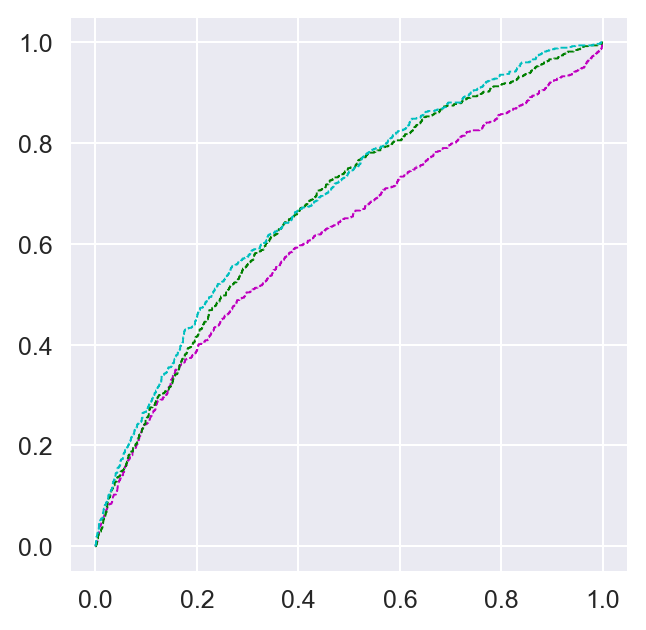

In [5]:
cedar_baseline = pd.read_csv('../data/baselines/cedar_baseline.csv')
cedar_related_baseline = pd.read_csv('../data/baselines/cedar_related_baseline.csv')
prime = pd.read_csv('../data/baselines/prime_baseline.csv')
prime_related_baseline = pd.read_csv('../data/baselines/prime_related_baseline.csv')
f,a = plt.subplots(1,1, figsize=(4,4))
plot_baseline_roc(a, cedar_baseline)

In [7]:
from src.baselines import plot_related_baseline_roc

Text(0.5, 1.0, 'Baseline ROCs on IBEL')

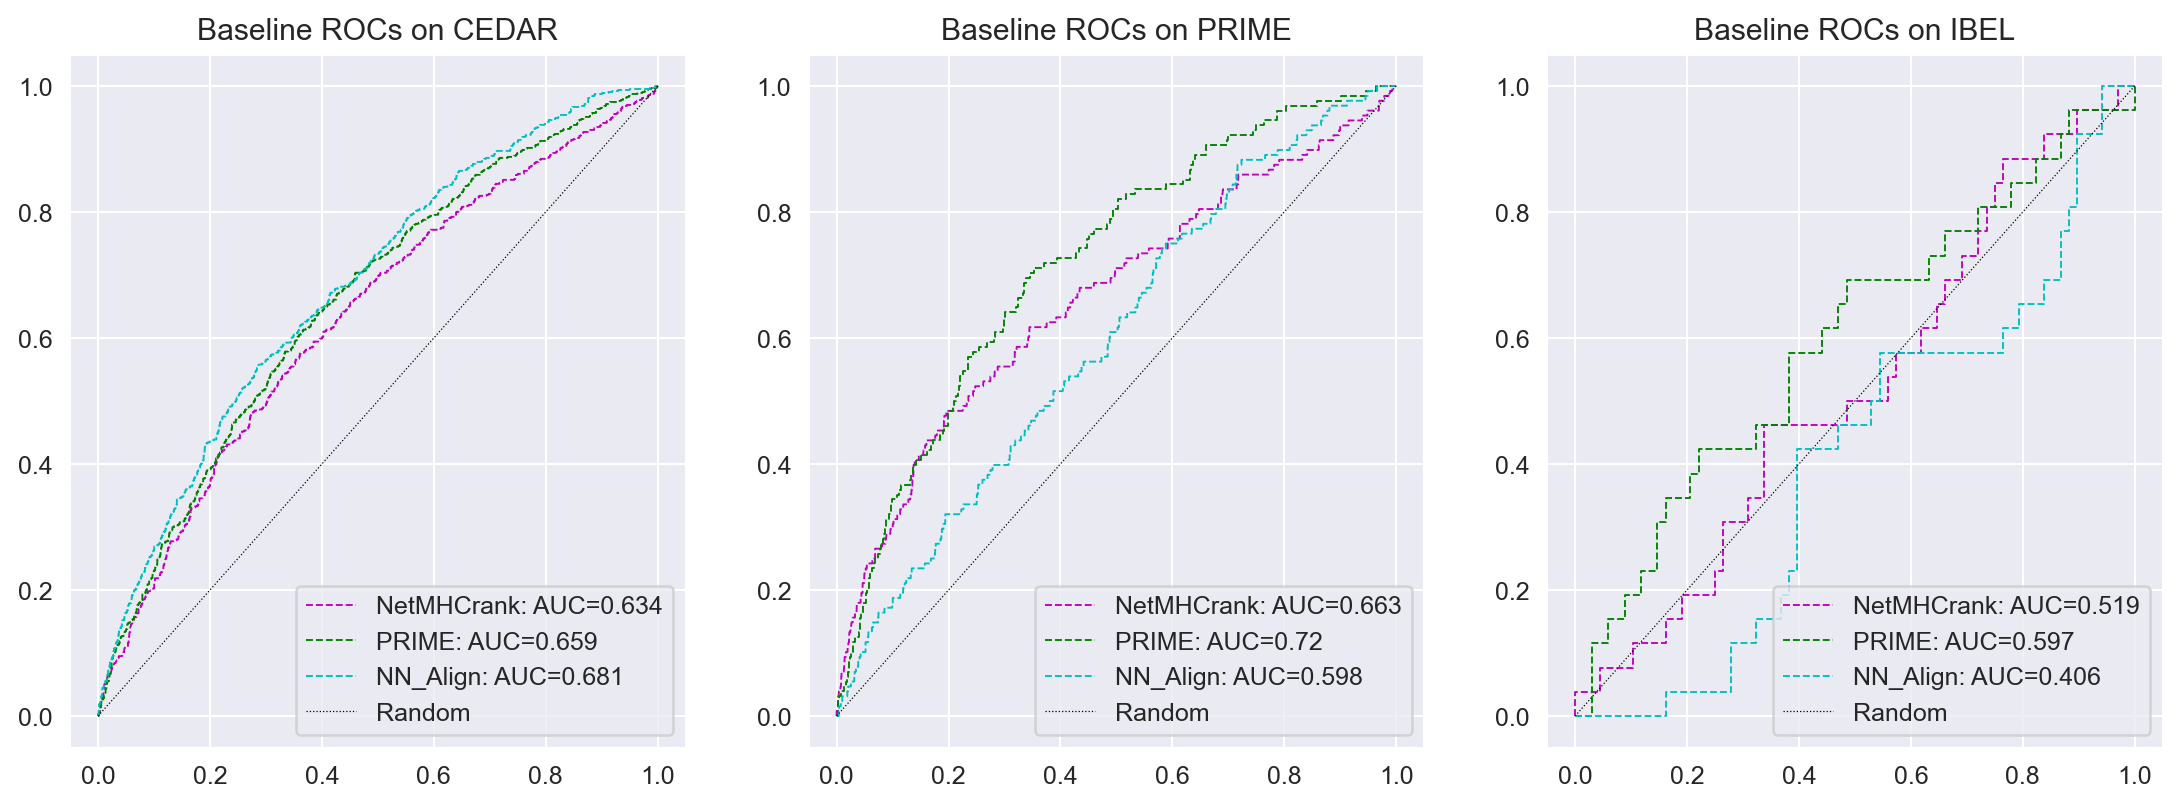

In [6]:
f,a = plt.subplots(1,3, figsize=(15,5))
plot_related_baseline_roc(axis=a[1], dataset=prime_related_baseline)
# a[1].plot([0,1],[0,1], label='Random', ls='--', lw=0.5, c='k')
a[1].legend(loc='lower right')
a[1].set_title('Baseline ROCs on PRIME')
plot_related_baseline_roc(axis=a[0], dataset=cedar_related_baseline)
# a[0].plot([0,1],[0,1], label='Random', ls='--', lw=0.5, c='k')
a[0].legend(loc='lower right')
a[0].set_title('Baseline ROCs on CEDAR')

plot_related_baseline_roc(axis=a[2], dataset=ibel)
# a[2].plot([0,1],[0,1], label='Random', ls='--', lw=0.5, c='k')
a[2].legend(loc='lower right')
a[2].set_title('Baseline ROCs on IBEL')

## rocs

In [9]:
# Trained on CEDAR
train_cedar_best_cedar_eval_cedar = pkl_load('../output/best_conditions/cedar/best_cedar/CEDAR_mean_rocs_onehot_Inverted-KL_Peptide_EL_rank_mut_aa_props.pkl')
train_cedar_best_cedar_eval_prime = pkl_load('../output/best_conditions/cedar/best_cedar/PRIME_mean_rocs_onehot_Inverted-KL_Peptide_EL_rank_mut_aa_props.pkl')
train_cedar_best_cedar_eval_ibel = pkl_load('../output/best_conditions/cedar/best_cedar/IBEL_mean_rocs_onehot_Inverted-KL_Peptide_EL_rank_mut_aa_props.pkl')
train_cedar_best_prime_eval_cedar = pkl_load('../output/best_conditions/cedar/best_prime/CEDAR_mean_rocs_onehot_Mask_Peptide_EL_rank_mut_core_blsm_mut_score-core_mutation_score.pkl')
train_cedar_best_prime_eval_prime = pkl_load('../output/best_conditions/cedar/best_prime/PRIME_mean_rocs_onehot_Mask_Peptide_EL_rank_mut_core_blsm_mut_score-core_mutation_score.pkl')
train_cedar_best_prime_eval_ibel = pkl_load('../output/best_conditions/cedar/best_prime/IBEL_mean_rocs_onehot_Mask_Peptide_EL_rank_mut_core_blsm_mut_score-core_mutation_score.pkl')

# Trained on PRIME
train_prime_best_cedar_eval_cedar = pkl_load('../output/best_conditions/prime/best_cedar/CEDAR_mean_rocs_onehot_Mask_icore_mut_EL_rank_mut_dissimilarity_score-blsm_mut_score.pkl')
train_prime_best_cedar_eval_prime = pkl_load('../output/best_conditions/prime/best_cedar/PRIME_mean_rocs_onehot_Mask_icore_mut_EL_rank_mut_dissimilarity_score-blsm_mut_score.pkl')
train_prime_best_cedar_eval_ibel = pkl_load('../output/best_conditions/prime/best_cedar/IBEL_mean_rocs_onehot_Mask_icore_mut_EL_rank_mut_dissimilarity_score-blsm_mut_score.pkl')
train_prime_best_prime_eval_cedar = pkl_load('../output/best_conditions/prime/best_prime/CEDAR_mean_rocs_onehot_Mask_Peptide_EL_rank_mut_blsm_mut_score.pkl')
train_prime_best_prime_eval_prime = pkl_load('../output/best_conditions/prime/best_prime/PRIME_mean_rocs_onehot_Mask_Peptide_EL_rank_mut_blsm_mut_score.pkl')
train_prime_best_prime_eval_ibel = pkl_load('../output/best_conditions/prime/best_prime/IBEL_mean_rocs_onehot_Mask_Peptide_EL_rank_mut_blsm_mut_score.pkl')

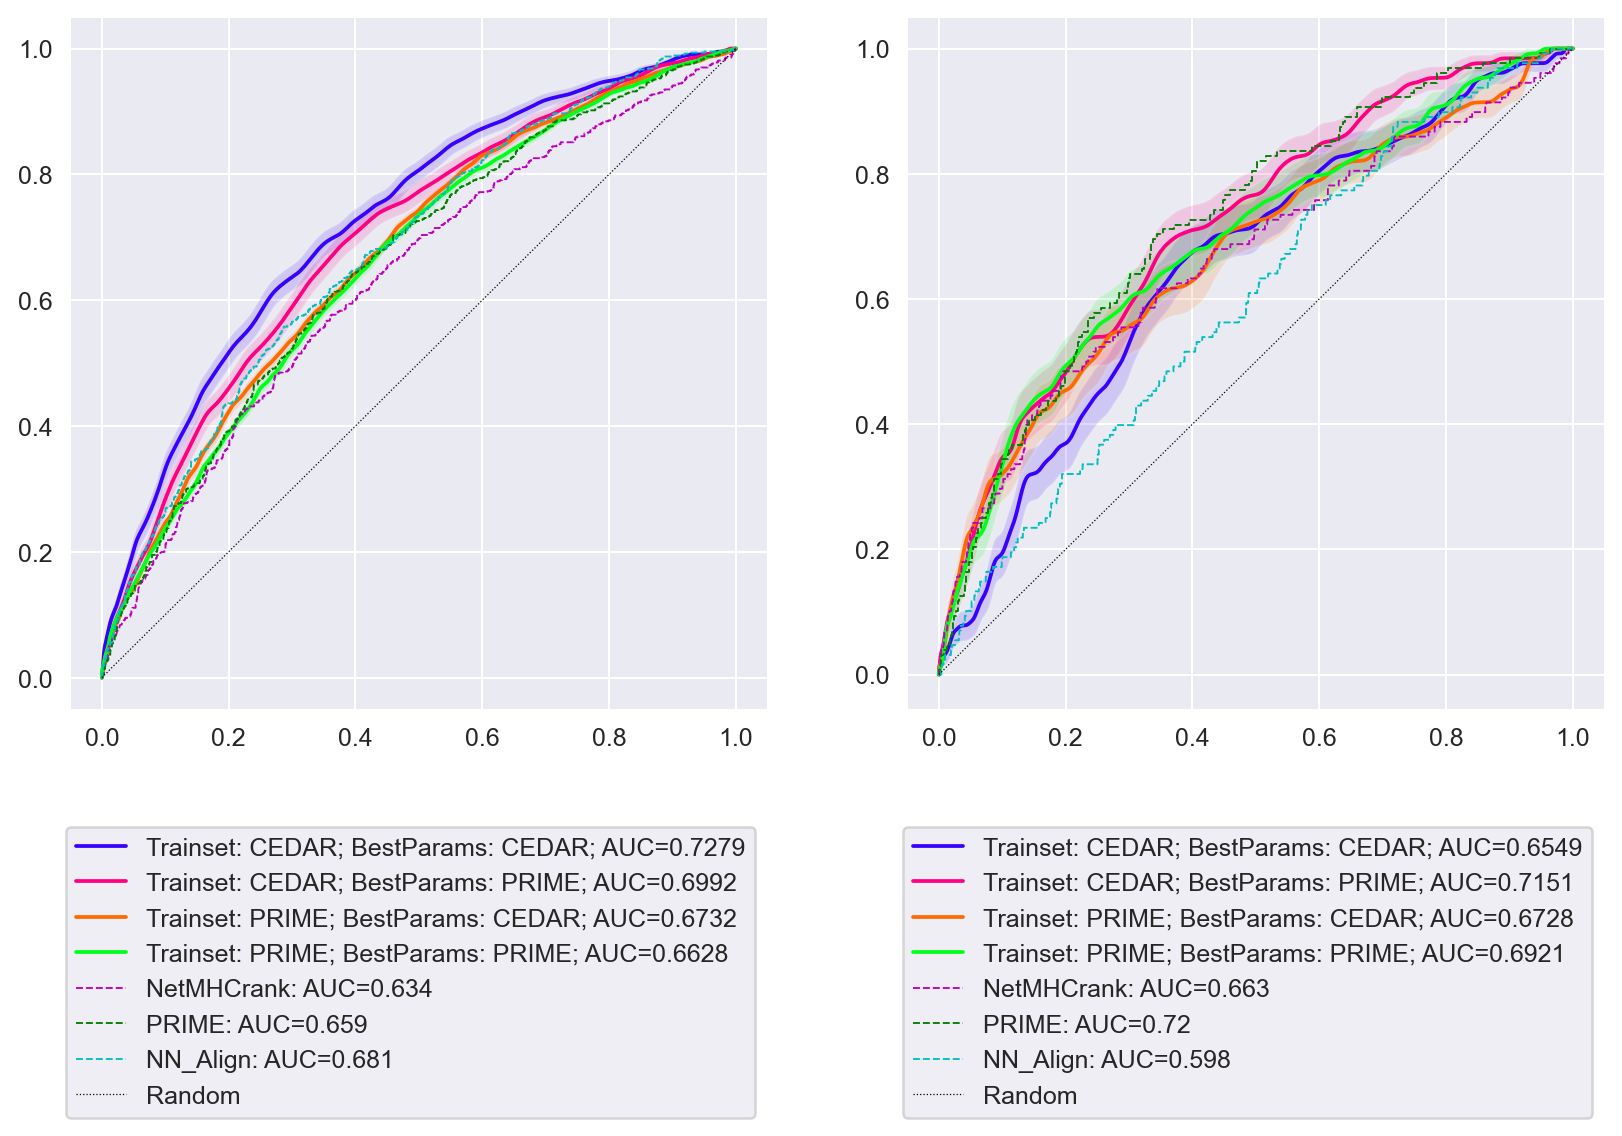

In [18]:
f,a = plt.subplots(1,2, figsize=(11,5))
# Plot CEDAR eval
## Trained on CEDAR
sns.lineplot(x=train_cedar_best_cedar_eval_cedar[0], 
             y=train_cedar_best_cedar_eval_cedar[1], ax = a[0], estimator=None,
             label = f'Trainset: CEDAR; BestParams: CEDAR; AUC={round(train_cedar_best_cedar_eval_cedar[-1],4)}')
a[0].fill_between(np.linspace(0, 1, len(train_cedar_best_cedar_eval_cedar[0])),
               train_cedar_best_cedar_eval_cedar[2], 
               train_cedar_best_cedar_eval_cedar[3], alpha=0.15)

sns.lineplot(x=train_cedar_best_prime_eval_cedar[0], 
             y=train_cedar_best_prime_eval_cedar[1], ax = a[0], estimator=None,
             label = f'Trainset: CEDAR; BestParams: PRIME; AUC={round(train_cedar_best_prime_eval_cedar[-1],4)}')
a[0].fill_between(np.linspace(0, 1, len(train_cedar_best_prime_eval_cedar[0])),
               train_cedar_best_prime_eval_cedar[2], 
               train_cedar_best_prime_eval_cedar[3], alpha=0.15)

## Trained on PRIME
sns.lineplot(x=train_prime_best_cedar_eval_cedar[0], 
             y=train_prime_best_cedar_eval_cedar[1], ax = a[0], estimator=None,
             label = f'Trainset: PRIME; BestParams: CEDAR; AUC={round(train_prime_best_cedar_eval_cedar[-1],4)}')
a[0].fill_between(np.linspace(0, 1, len(train_prime_best_cedar_eval_cedar[0])),
               train_prime_best_cedar_eval_cedar[2], 
               train_prime_best_cedar_eval_cedar[3], alpha=0.15)

sns.lineplot(x=train_prime_best_prime_eval_cedar[0], 
             y=train_prime_best_prime_eval_cedar[1], ax = a[0], estimator=None,
             label = f'Trainset: PRIME; BestParams: PRIME; AUC={round(train_prime_best_prime_eval_cedar[-1],4)}')
a[0].fill_between(np.linspace(0, 1, len(train_prime_best_prime_eval_cedar[0])),
               train_prime_best_prime_eval_cedar[2], 
               train_prime_best_prime_eval_cedar[3], alpha=0.15)


# Plot PRIME eval
## Trained on CEDAR
sns.lineplot(x=train_cedar_best_cedar_eval_prime[0], 
             y=train_cedar_best_cedar_eval_prime[1], ax = a[1], estimator=None,
             label = f'Trainset: CEDAR; BestParams: CEDAR; AUC={round(train_cedar_best_cedar_eval_prime[-1],4)}')
a[1].fill_between(np.linspace(0, 1, len(train_cedar_best_cedar_eval_prime[0])),
               train_cedar_best_cedar_eval_prime[2], 
               train_cedar_best_cedar_eval_prime[3], alpha=0.15)

sns.lineplot(x=train_cedar_best_prime_eval_prime[0], 
             y=train_cedar_best_prime_eval_prime[1], ax = a[1], estimator=None,
             label = f'Trainset: CEDAR; BestParams: PRIME; AUC={round(train_cedar_best_prime_eval_prime[-1],4)}')
a[1].fill_between(np.linspace(0, 1, len(train_cedar_best_prime_eval_prime[0])),
               train_cedar_best_prime_eval_prime[2], 
               train_cedar_best_prime_eval_prime[3], alpha=0.15)

## Trained on PRIME
sns.lineplot(x=train_prime_best_cedar_eval_prime[0], 
             y=train_prime_best_cedar_eval_prime[1], ax = a[1], estimator=None,
             label = f'Trainset: PRIME; BestParams: CEDAR; AUC={round(train_prime_best_cedar_eval_prime[-1],4)}')
a[1].fill_between(np.linspace(0, 1, len(train_prime_best_cedar_eval_prime[0])),
               train_prime_best_cedar_eval_prime[2], 
               train_prime_best_cedar_eval_prime[3], alpha=0.15)

sns.lineplot(x=train_prime_best_prime_eval_prime[0], 
             y=train_prime_best_prime_eval_prime[1], ax = a[1], estimator=None,
             label = f'Trainset: PRIME; BestParams: PRIME; AUC={round(train_prime_best_prime_eval_prime[-1],4)}')
a[1].fill_between(np.linspace(0, 1, len(train_prime_best_prime_eval_prime[0])),
               train_prime_best_prime_eval_prime[2], 
               train_prime_best_prime_eval_prime[3], alpha=0.15)

plot_related_baseline_roc(a[0], cedar_related_baseline)
plot_related_baseline_roc(a[1], prime_related_baseline)

a[0].legend(bbox_to_anchor = (1,-.15))
a[1].legend(bbox_to_anchor = (1,-.15))


# # Plot IBEL eval
# ## Trained on CEDAR
# sns.lineplot(x=train_cedar_best_cedar_eval_ibel[0], 
#              y=train_cedar_best_cedar_eval_ibel[1], ax = a[2], estimator=None,
#              label = f'Trainset: CEDAR; BestParams: CEDAR; AUC={round(train_cedar_best_cedar_eval_ibel[-1],4)}')
# a[2].fill_between(np.linspace(0, 1, len(train_cedar_best_cedar_eval_ibel[0])),
#                train_cedar_best_cedar_eval_ibel[2], 
#                train_cedar_best_cedar_eval_ibel[3], alpha=0.15)

# sns.lineplot(x=train_cedar_best_prime_eval_ibel[0], 
#              y=train_cedar_best_prime_eval_ibel[1], ax = a[2], estimator=None,
#              label = f'Trainset: CEDAR; BestParams: PRIME; AUC={round(train_cedar_best_prime_eval_ibel[-1],4)}')
# a[2].fill_between(np.linspace(0, 1, len(train_cedar_best_prime_eval_ibel[0])),
#                train_cedar_best_prime_eval_ibel[2], 
#                train_cedar_best_prime_eval_ibel[3], alpha=0.15)

# ## Trained on PRIME
# sns.lineplot(x=train_prime_best_cedar_eval_ibel[0], 
#              y=train_prime_best_cedar_eval_ibel[1], ax = a[2], estimator=None,
#              label = f'Trainset: PRIME; BestParams: CEDAR; AUC={round(train_prime_best_cedar_eval_ibel[-1],4)}')
# a[2].fill_between(np.linspace(0, 1, len(train_prime_best_cedar_eval_ibel[0])),
#                train_prime_best_cedar_eval_ibel[2], 
#                train_prime_best_cedar_eval_ibel[3], alpha=0.15)

# sns.lineplot(x=train_prime_best_prime_eval_ibel[0], 
#              y=train_prime_best_prime_eval_ibel[1], ax = a[2], estimator=None,
#              label = f'Trainset: PRIME; BestParams: PRIME; AUC={round(train_prime_best_prime_eval_ibel[-1],4)}')
# a[2].fill_between(np.linspace(0, 1, len(train_prime_best_prime_eval_ibel[0])),
#                train_prime_best_prime_eval_ibel[2], 
#                train_prime_best_prime_eval_ibel[3], alpha=0.15)


### ibel rocs

In [ ]:
train_cedar_best_ibel_eval_ibel = pkl_load('../output/best_conditions/cedar/best_ibel/IBEL_mean_rocs_BL62LO_Mask_Peptide_trueHLA_EL_rank_dissimilarity_score-core_blsm_mut_score.pkl')
train_merged_best_ibel_eval_ibel = pkl_load('../output/best_conditions/merged/best_ibel/
train_prime_best_ibel_eval_ibel = pkl_load('../output/best_conditions/prime/best_ibel/
